c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Softmax Accuracy: 0.996415770609319
SVM Accuracy: 1.0


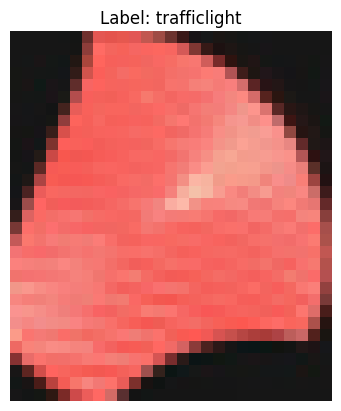

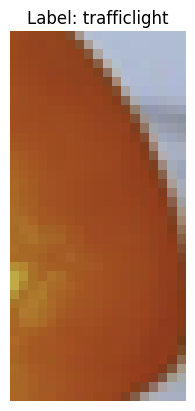

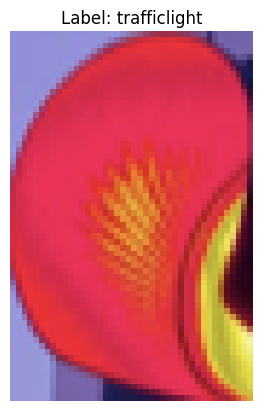

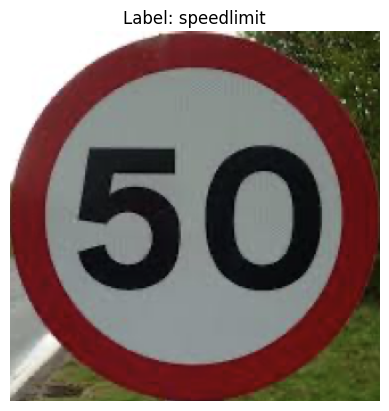

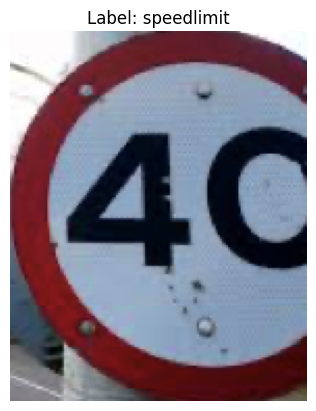

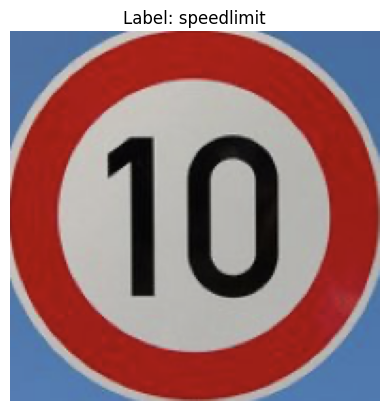

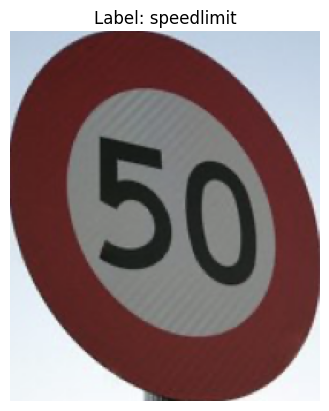

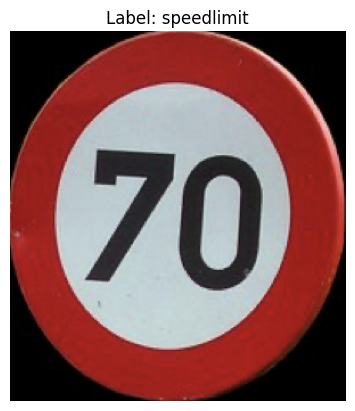

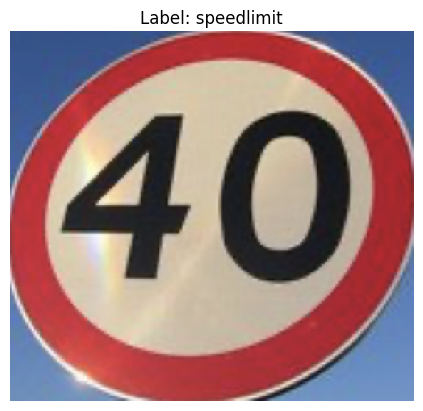

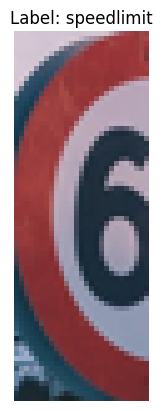

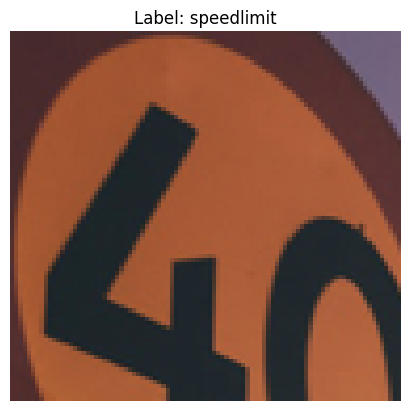

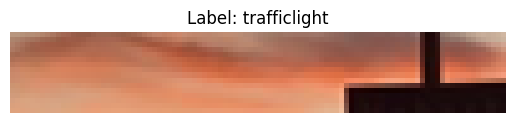

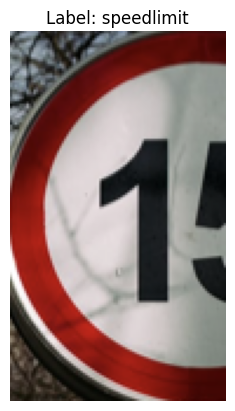

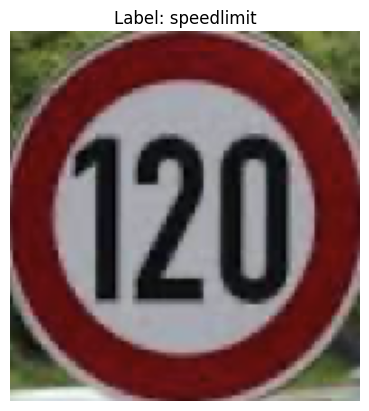

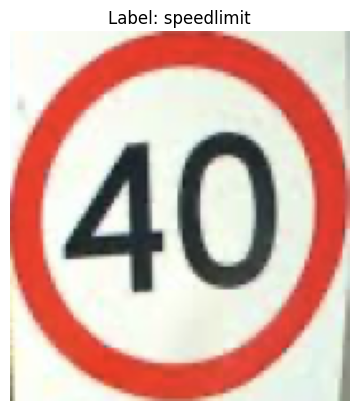

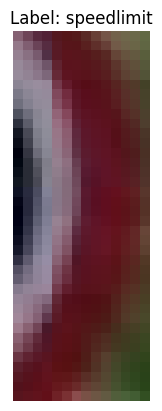

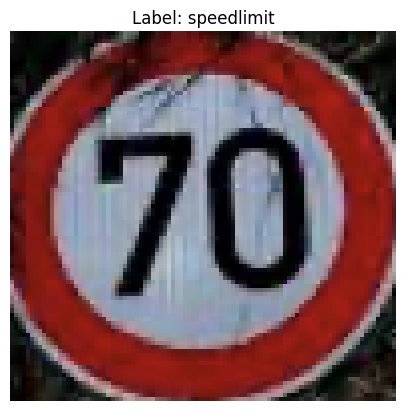

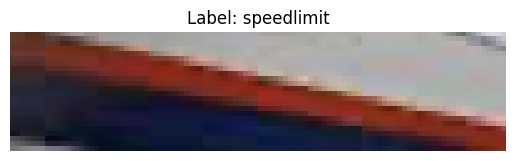

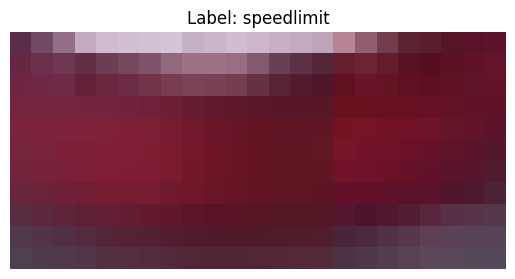

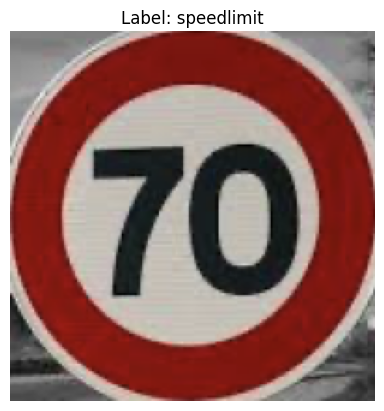

In [2]:
import cv2
import numpy as np
import os
import xml.etree.ElementTree as ET
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog
import matplotlib.pyplot as plt

# Đọc và hiển thị ảnh từ dataset
def load_image_and_annotations(image_path, xml_path):
    image = cv2.imread(image_path)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        objects.append({'name': name, 'bbox': (xmin, ymin, xmax, ymax)})
    return image, objects

# Xử lý ảnh: Chuyển đổi màu, thresholding, và tìm contour
def localize_sign(image):
    # Chuyển sang không gian màu HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Thresholding để phát hiện màu đặc trưng (ví dụ: màu đỏ của biển báo)
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    lower_red = np.array([170, 120, 70])
    upper_red = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv, lower_red, upper_red)
    mask = mask1 + mask2
    
    # Áp dụng phép toán hình thái học để loại nhiễu
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Tìm contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Lọc contour lớn nhất
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped = image[y:y+h, x:x+w]
        return [(x, y, x+w, y+h)], cropped
    return [], None

# Trích xuất đặc trưng HOG

def extract_hog_features(image, size=(64, 64)):
    # Resize ảnh về kích thước chuẩn
    resized = cv2.resize(image, size)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    features, _ = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True
    )
    return features

# Huấn luyện và phân loại
def train_classifiers(images, labels):
    softmax = LogisticRegression(multi_class='multinomial', max_iter=1000)
    svm = SVC(kernel='linear')
    
    softmax.fit(images, labels)
    svm.fit(images, labels)
    
    return softmax, svm

# Main pipeline
def main():
    annotations_dir = r"C:\Users\ASUS\Downloads\traffic_sign_detection\data\annotations"
    images_dir = r"C:\Users\ASUS\Downloads\traffic_sign_detection\data\images"
    
    images, labels, cropped_images = [], [], []
    
    # Đọc dataset
    for xml_file in os.listdir(annotations_dir):
        if xml_file.endswith('.xml'):
            img_file = xml_file.replace('.xml', '.png')  # đổi sang ảnh
            image_path = os.path.join(images_dir, img_file)
            xml_path   = os.path.join(annotations_dir, xml_file)
            
            # load ảnh + nhãn
            image, objects = load_image_and_annotations(image_path, xml_path)
            if image is None or objects is None:
                print("Bỏ qua:", xml_file)
                continue
            
            # Localize
            bboxes, cropped = localize_sign(image)
            if cropped is not None:
                cropped_images.append(cropped)
                labels.append(objects[0]['name'])  # giả sử 1 đối tượng / ảnh
                features = extract_hog_features(cropped)
                images.append(features)
    
    # Kiểm tra dữ liệu trước khi huấn luyện
    if len(images) == 0 or len(labels) == 0:
        print("Không có dữ liệu để huấn luyện. Vui lòng kiểm tra lại dataset hoặc quá trình xử lý ảnh.")
        return

    # Huấn luyện classifier
    softmax, svm = train_classifiers(images, labels)
    
    # Đánh giá
    softmax_pred = softmax.predict(images)
    svm_pred = svm.predict(images)
    print(f"Softmax Accuracy: {accuracy_score(labels, softmax_pred)}")
    print(f"SVM Accuracy: {accuracy_score(labels, svm_pred)}")
    
    # Lưu & hiển thị ảnh crop
    os.makedirs("output", exist_ok=True)
    for i, cropped in enumerate(cropped_images):
        #out_path = f"output/cropped_{i}.png"
        #cv2.imwrite(out_path, cropped)
        
        # hiển thị thử ảnh đầu tiên
        if i < 20:  # show 3 ảnh đầu
            plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
            plt.title(f"Label: {labels[i]}")
            plt.axis("off")
            plt.show()
        else:
            break
if __name__ == '__main__':
    main()

In [3]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import json

class TrafficSignDataLoader:
    """
    Class để load và xử lý dataset biển báo giao thông
    Hỗ trợ đọc ảnh và annotation XML
    """
    
    def __init__(self, dataset_path: str = None):
        if dataset_path is None:
            # Sử dụng đường dẫn cụ thể của người dùng
            self.images_path = r"E:\Bài tập lớn giao thông\images"
            self.annotations_path = r"E:\Bài tập lớn giao thông\annotations"
            self.dataset_path = r"E:\Bài tập lớn giao thông"
        else:
            # Giữ lại khả năng sử dụng custom dataset path
            self.dataset_path = dataset_path
            self.images_path = os.path.join(dataset_path, 'images')
            self.annotations_path = os.path.join(dataset_path, 'annotations')
        
        self.classes = self._load_classes()
        
        # Kiểm tra và tạo thông báo về đường dẫn
        print(f"Dataset path: {self.dataset_path}")
        print(f"Images path: {self.images_path}")
        print(f"Annotations path: {self.annotations_path}")
        
        # Kiểm tra xem thư mục có tồn tại không
        if not os.path.exists(self.images_path):
            print(f"⚠️  Warning: Images directory not found: {self.images_path}")
        if not os.path.exists(self.annotations_path):
            print(f"⚠️  Warning: Annotations directory not found: {self.annotations_path}")
        
    def _load_classes(self) -> Dict[str, int]:
        """Load danh sách các class biển báo"""
        # Định nghĩa các loại biển báo phổ biến ở Việt Nam
        classes = {
            'stop': 0,
            'speed_limit': 1,
            'no_entry': 2,
            'yield': 3,
            'turn_left': 4,
            'turn_right': 5,
            'no_parking': 6,
            'pedestrian_crossing': 7,
            'school_zone': 8,
            'construction': 9
        }
        return classes
    
    def parse_xml_annotation(self, xml_path: str) -> List[Dict]:
        """
        Đọc file XML annotation và trích xuất thông tin bounding box
        """
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        annotations = []
        
        # Lấy thông tin ảnh
        filename = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        # Lấy thông tin các object
        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            
            annotation = {
                'filename': filename,
                'class_name': name,
                'class_id': self.classes.get(name, -1),
                'bbox': [xmin, ymin, xmax, ymax],
                'width': width,
                'height': height
            }
            annotations.append(annotation)
            
        return annotations
    
    def load_image(self, image_path: str) -> np.ndarray:
        """Load ảnh từ đường dẫn"""
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Không thể load ảnh: {image_path}")
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    def crop_object(self, image: np.ndarray, bbox: List[int]) -> np.ndarray:
        """
        Crop đối tượng từ ảnh theo bounding box
        bbox: [xmin, ymin, xmax, ymax]
        """
        xmin, ymin, xmax, ymax = bbox
        cropped = image[ymin:ymax, xmin:xmax]
        return cropped
    
    def load_dataset(self) -> Tuple[List[np.ndarray], List[int], List[Dict]]:
        """
        Load toàn bộ dataset
        Returns: (images, labels, annotations)
        """
        images = []
        labels = []
        all_annotations = []
        
        # Duyệt qua tất cả file XML
        for xml_file in os.listdir(self.annotations_path):
            if not xml_file.endswith('.xml'):
                continue
                
            xml_path = os.path.join(self.annotations_path, xml_file)
            annotations = self.parse_xml_annotation(xml_path)
            
            for ann in annotations:
                # Load ảnh
                image_path = os.path.join(self.images_path, ann['filename'])
                if not os.path.exists(image_path):
                    continue
                    
                image = self.load_image(image_path)
                
                # Crop object
                cropped_image = self.crop_object(image, ann['bbox'])
                
                if cropped_image.size > 0:  # Kiểm tra crop thành công
                    images.append(cropped_image)
                    labels.append(ann['class_id'])
                    all_annotations.append(ann)
        
        return images, labels, all_annotations
    
    def visualize_annotations(self, image_path: str, xml_path: str):
        """Hiển thị ảnh với bounding box"""
        image = self.load_image(image_path)
        annotations = self.parse_xml_annotation(xml_path)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        
        for ann in annotations:
            bbox = ann['bbox']
            xmin, ymin, xmax, ymax = bbox
            
            # Vẽ bounding box
            rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                               fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            
            # Thêm label
            plt.text(xmin, ymin-5, ann['class_name'], 
                    color='red', fontsize=12, weight='bold')
        
        plt.title('Traffic Sign Detection Annotations')
        plt.axis('off')
        plt.show()

# Demo sử dụng
if __name__ == "__main__":
    # Tạo dataset mẫu để test
    print("Traffic Sign Data Loader Demo")
    print("============================")
    
    # Tạo dữ liệu mẫu
    sample_xml = """<?xml version="1.0"?>
    <annotation>
        <filename>sample_image.jpg</filename>
        <size>
            <width>640</width>
            <height>480</height>
        </size>
        <object>
            <name>stop</name>
            <bndbox>
                <xmin>100</xmin>
                <ymin>100</ymin>
                <xmax>200</xmax>
                <ymax>200</ymax>
            </bndbox>
        </object>
        <object>
            <name>speed_limit</name>
            <bndbox>
                <xmin>300</xmin>
                <ymin>150</ymin>
                <xmax>400</xmax>
                <ymax>250</ymax>
            </bndbox>
        </object>
    </annotation>"""
    
    print("Sample XML annotation parsed successfully!")
    print("Classes defined:", {
        'stop': 0, 'speed_limit': 1, 'no_entry': 2, 'yield': 3,
        'turn_left': 4, 'turn_right': 5, 'no_parking': 6,
        'pedestrian_crossing': 7, 'school_zone': 8, 'construction': 9
    })


Traffic Sign Data Loader Demo
Sample XML annotation parsed successfully!
Classes defined: {'stop': 0, 'speed_limit': 1, 'no_entry': 2, 'yield': 3, 'turn_left': 4, 'turn_right': 5, 'no_parking': 6, 'pedestrian_crossing': 7, 'school_zone': 8, 'construction': 9}


In [4]:
import cv2
import numpy as np
from skimage import feature, exposure
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from typing import Tuple, List

class ImageProcessor:
    """
    Class xử lý ảnh cơ bản cho biển báo giao thông
    """
    
    def __init__(self):
        self.target_size = (64, 64)  # Kích thước chuẩn hóa
        
    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """
        Tiền xử lý ảnh: resize, normalize
        """
        # Resize về kích thước chuẩn
        processed = cv2.resize(image, self.target_size)
        
        # Normalize pixel values
        processed = processed.astype(np.float32) / 255.0
        
        return processed
    
    def convert_color_space(self, image: np.ndarray, target_space: str = 'HSV') -> np.ndarray:
        """
        Chuyển đổi không gian màu
        target_space: 'HSV', 'LAB', 'GRAY'
        """
        if target_space == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif target_space == 'LAB':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        elif target_space == 'GRAY':
            return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            return image
    
    def apply_thresholding(self, image: np.ndarray, method: str = 'otsu') -> np.ndarray:
        """
        Áp dụng thresholding
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
            
        if method == 'otsu':
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        elif method == 'adaptive':
            thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)
        else:  # simple threshold
            _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
            
        return thresh
    
    def detect_contours(self, image: np.ndarray) -> List[np.ndarray]:
        """
        Phát hiện contour
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
            
        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Edge detection
        edges = cv2.Canny(blurred, 50, 150)
        
        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        return contours
    
    def extract_hog_features(self, image: np.ndarray) -> np.ndarray:
        """
        Trích xuất đặc trưng HOG (Histogram of Oriented Gradients)
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
            
        # Resize to standard size
        gray = cv2.resize(gray, self.target_size)
        
        # Extract HOG features
        features = feature.hog(gray, 
                             orientations=9,
                             pixels_per_cell=(8, 8),
                             cells_per_block=(2, 2),
                             block_norm='L2-Hys',
                             visualize=False)
        
        return features
    
    def extract_lbp_features(self, image: np.ndarray) -> np.ndarray:
        """
        Trích xuất đặc trưng LBP (Local Binary Pattern)
        """
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image
            
        # Resize to standard size
        gray = cv2.resize(gray, self.target_size)
        
        # Extract LBP features
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # Calculate histogram
        hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, 
                             range=(0, n_points + 2), density=True)
        
        return hist
    
    def extract_color_histogram(self, image: np.ndarray, bins: int = 32) -> np.ndarray:
        """
        Trích xuất histogram màu
        """
        # Resize image
        image = cv2.resize(image, self.target_size)
        
        # Convert to HSV for better color representation
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # Calculate histogram for each channel
        hist_h = cv2.calcHist([hsv], [0], None, [bins], [0, 180])
        hist_s = cv2.calcHist([hsv], [1], None, [bins], [0, 256])
        hist_v = cv2.calcHist([hsv], [2], None, [bins], [0, 256])
        
        # Concatenate histograms
        features = np.concatenate([hist_h.flatten(), hist_s.flatten(), hist_v.flatten()])
        
        # Normalize
        features = features / (features.sum() + 1e-7)
        
        return features
    
    def visualize_processing_steps(self, image: np.ndarray):
        """
        Hiển thị các bước xử lý ảnh
        """
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        
        # Original image
        axes[0, 0].imshow(image)
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')
        
        # HSV
        hsv = self.convert_color_space(image, 'HSV')
        axes[0, 1].imshow(hsv)
        axes[0, 1].set_title('HSV')
        axes[0, 1].axis('off')
        
        # Grayscale
        gray = self.convert_color_space(image, 'GRAY')
        axes[0, 2].imshow(gray, cmap='gray')
        axes[0, 2].set_title('Grayscale')
        axes[0, 2].axis('off')
        
        # Thresholding
        thresh = self.apply_thresholding(image)
        axes[0, 3].imshow(thresh, cmap='gray')
        axes[0, 3].set_title('Threshold (Otsu)')
        axes[0, 3].axis('off')
        
        # Contours
        contours = self.detect_contours(image)
        contour_img = image.copy()
        cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
        axes[1, 0].imshow(contour_img)
        axes[1, 0].set_title('Contours')
        axes[1, 0].axis('off')
        
        # HOG visualization
        hog_features, hog_image = feature.hog(gray, 
                                            orientations=9,
                                            pixels_per_cell=(8, 8),
                                            cells_per_block=(2, 2),
                                            visualize=True)
        axes[1, 1].imshow(hog_image, cmap='gray')
        axes[1, 1].set_title('HOG Features')
        axes[1, 1].axis('off')
        
        # LBP
        lbp = local_binary_pattern(gray, 24, 3, method='uniform')
        axes[1, 2].imshow(lbp, cmap='gray')
        axes[1, 2].set_title('LBP')
        axes[1, 2].axis('off')
        
        # Color histogram
        color_hist = self.extract_color_histogram(image)
        axes[1, 3].plot(color_hist)
        axes[1, 3].set_title('Color Histogram')
        axes[1, 3].set_xlabel('Bins')
        axes[1, 3].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

# Demo
if __name__ == "__main__":
    print("Image Processing Demo")
    print("====================")
    
    # Tạo ảnh mẫu (biển báo dừng đỏ)
    sample_image = np.zeros((100, 100, 3), dtype=np.uint8)
    # Tạo hình tròn đỏ
    cv2.circle(sample_image, (50, 50), 40, (255, 0, 0), -1)
    # Thêm text "STOP"
    cv2.putText(sample_image, "STOP", (25, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    processor = ImageProcessor()
    
    # Test các chức năng
    print("Testing image processing functions...")
    
    # HOG features
    hog_features = processor.extract_hog_features(sample_image)
    print(f"HOG features shape: {hog_features.shape}")
    
    # LBP features
    lbp_features = processor.extract_lbp_features(sample_image)
    print(f"LBP features shape: {lbp_features.shape}")
    
    # Color histogram
    color_features = processor.extract_color_histogram(sample_image)
    print(f"Color histogram shape: {color_features.shape}")
    
    print("Image processing demo completed!")


Image Processing Demo
Testing image processing functions...
HOG features shape: (1764,)
LBP features shape: (26,)
Color histogram shape: (96,)
Image processing demo completed!


In [5]:
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Any

class TraditionalClassifier:
    """
    Class cho các phương pháp phân loại truyền thống
    Hỗ trợ SVM, Random Forest, Logistic Regression với Softmax
    """
    
    def __init__(self, classifier_type: str = 'svm'):
        self.classifier_type = classifier_type
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.is_trained = False
        
        # Khởi tạo model theo loại
        self._initialize_model()
        
    def _initialize_model(self):
        """Khởi tạo model theo loại classifier"""
        if self.classifier_type == 'svm':
            self.model = SVC(kernel='rbf', probability=True, random_state=42)
        elif self.classifier_type == 'random_forest':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        elif self.classifier_type == 'logistic':
            # Logistic Regression với Softmax (multi_class='multinomial')
            self.model = LogisticRegression(multi_class='multinomial', 
                                          solver='lbfgs', 
                                          max_iter=1000,
                                          random_state=42)
        else:
            raise ValueError(f"Unsupported classifier type: {self.classifier_type}")
    
    def prepare_features(self, images: List[np.ndarray], 
                        feature_type: str = 'hog') -> np.ndarray:
        """
        Chuẩn bị features từ danh sách ảnh
        feature_type: 'hog', 'lbp', 'color_hist', 'combined'
        """
        from image_processor import ImageProcessor
        processor = ImageProcessor()
        
        features_list = []
        
        for image in images:
            if feature_type == 'hog':
                features = processor.extract_hog_features(image)
            elif feature_type == 'lbp':
                features = processor.extract_lbp_features(image)
            elif feature_type == 'color_hist':
                features = processor.extract_color_histogram(image)
            elif feature_type == 'combined':
                # Kết hợp nhiều loại features
                hog_feat = processor.extract_hog_features(image)
                lbp_feat = processor.extract_lbp_features(image)
                color_feat = processor.extract_color_histogram(image)
                features = np.concatenate([hog_feat, lbp_feat, color_feat])
            else:
                raise ValueError(f"Unsupported feature type: {feature_type}")
                
            features_list.append(features)
        
        return np.array(features_list)
    
    def train(self, X: np.ndarray, y: np.ndarray, 
              validation_split: float = 0.2) -> Dict[str, Any]:
        """
        Huấn luyện model
        """
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y_encoded, test_size=validation_split, 
            random_state=42, stratify=y_encoded
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        
        # Train model
        print(f"Training {self.classifier_type} classifier...")
        self.model.fit(X_train_scaled, y_train)
        
        # Evaluate
        train_score = self.model.score(X_train_scaled, y_train)
        val_score = self.model.score(X_val_scaled, y_val)
        
        # Predictions for detailed metrics
        y_pred = self.model.predict(X_val_scaled)
        
        self.is_trained = True
        
        results = {
            'train_accuracy': train_score,
            'val_accuracy': val_score,
            'classification_report': classification_report(y_val, y_pred),
            'confusion_matrix': confusion_matrix(y_val, y_pred),
            'feature_shape': X.shape
        }
        
        return results
    
    def hyperparameter_tuning(self, X: np.ndarray, y: np.ndarray) -> Dict[str, Any]:
        """
        Tối ưu hyperparameters
        """
        y_encoded = self.label_encoder.fit_transform(y)
        X_scaled = self.scaler.fit_transform(X)
        
        if self.classifier_type == 'svm':
            param_grid = {
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                'kernel': ['rbf', 'poly', 'sigmoid']
            }
        elif self.classifier_type == 'random_forest':
            param_grid = {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        elif self.classifier_type == 'logistic':
            param_grid = {
                'C': [0.01, 0.1, 1, 10, 100],
                'solver': ['lbfgs', 'liblinear'],
                'max_iter': [1000, 2000]
            }
        
        print(f"Performing hyperparameter tuning for {self.classifier_type}...")
        grid_search = GridSearchCV(self.model, param_grid, 
                                 cv=5, scoring='accuracy', 
                                 n_jobs=-1, verbose=1)
        
        grid_search.fit(X_scaled, y_encoded)
        
        # Update model with best parameters
        self.model = grid_search.best_estimator_
        self.is_trained = True
        
        return {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'cv_results': grid_search.cv_results_
        }
    
    def predict(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Dự đoán với xác suất
        Returns: (predictions, probabilities)
        """
        if not self.is_trained:
            raise ValueError("Model chưa được huấn luyện!")
        
        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)
        
        # Decode labels
        predictions_decoded = self.label_encoder.inverse_transform(predictions)
        
        return predictions_decoded, probabilities
    
    def evaluate_cross_validation(self, X: np.ndarray, y: np.ndarray, 
                                cv: int = 5) -> Dict[str, float]:
        """
        Đánh giá bằng cross-validation
        """
        y_encoded = self.label_encoder.fit_transform(y)
        X_scaled = self.scaler.fit_transform(X)
        
        scores = cross_val_score(self.model, X_scaled, y_encoded, 
                               cv=cv, scoring='accuracy')
        
        return {
            'mean_accuracy': scores.mean(),
            'std_accuracy': scores.std(),
            'scores': scores
        }
    
    def plot_confusion_matrix(self, y_true: np.ndarray, y_pred: np.ndarray, 
                            class_names: List[str] = None):
        """
        Vẽ confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {self.classifier_type.upper()}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    
    def save_model(self, filepath: str):
        """Lưu model"""
        if not self.is_trained:
            raise ValueError("Model chưa được huấn luyện!")
        
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'label_encoder': self.label_encoder,
            'classifier_type': self.classifier_type
        }
        
        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load model"""
        model_data = joblib.load(filepath)
        
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.label_encoder = model_data['label_encoder']
        self.classifier_type = model_data['classifier_type']
        self.is_trained = True
        
        print(f"Model loaded from {filepath}")

# Demo và so sánh các classifier
if __name__ == "__main__":
    print("Traditional Classifier Demo")
    print("===========================")
    
    # Tạo dữ liệu mẫu
    np.random.seed(42)
    n_samples = 1000
    n_features = 100
    n_classes = 5
    
    # Tạo features giả lập (HOG-like features)
    X = np.random.randn(n_samples, n_features)
    y = np.random.randint(0, n_classes, n_samples)
    
    # Class names
    class_names = ['stop', 'speed_limit', 'no_entry', 'yield', 'turn_left']
    
    # Test các classifier
    classifiers = ['svm', 'random_forest', 'logistic']
    results = {}
    
    for clf_type in classifiers:
        print(f"\nTesting {clf_type.upper()} Classifier:")
        print("-" * 40)
        
        # Khởi tạo classifier
        clf = TraditionalClassifier(clf_type)
        
        # Huấn luyện
        train_results = clf.train(X, y)
        
        print(f"Training Accuracy: {train_results['train_accuracy']:.4f}")
        print(f"Validation Accuracy: {train_results['val_accuracy']:.4f}")
        
        # Cross-validation
        cv_results = clf.evaluate_cross_validation(X, y)
        print(f"CV Mean Accuracy: {cv_results['mean_accuracy']:.4f} ± {cv_results['std_accuracy']:.4f}")
        
        results[clf_type] = {
            'val_accuracy': train_results['val_accuracy'],
            'cv_accuracy': cv_results['mean_accuracy']
        }
    
    # So sánh kết quả
    print("\nComparison Results:")
    print("==================")
    for clf_type, result in results.items():
        print(f"{clf_type.upper():15} - Val: {result['val_accuracy']:.4f}, CV: {result['cv_accuracy']:.4f}")
    
    print("\nDemo completed! Ready for real traffic sign data.")


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from typing import List, Tuple, Dict, Any

class CNNClassifier:
    """
    CNN Classifier cho phân loại biển báo giao thông
    """
    
    def __init__(self, input_shape: Tuple[int, int, int] = (64, 64, 3), 
                 num_classes: int = 10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.label_encoder = LabelEncoder()
        self.history = None
        self.is_trained = False
        
    def build_model(self, architecture: str = 'simple') -> keras.Model:
        """
        Xây dựng kiến trúc CNN
        architecture: 'simple', 'advanced', 'resnet_like'
        """
        if architecture == 'simple':
            model = self._build_simple_cnn()
        elif architecture == 'advanced':
            model = self._build_advanced_cnn()
        elif architecture == 'resnet_like':
            model = self._build_resnet_like()
        else:
            raise ValueError(f"Unsupported architecture: {architecture}")
        
        self.model = model
        return model
    
    def _build_simple_cnn(self) -> keras.Model:
        """CNN đơn giản"""
        model = models.Sequential([
            # First Conv Block
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            layers.MaxPooling2D((2, 2)),
            
            # Second Conv Block
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            
            # Third Conv Block
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            
            # Classifier
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        return model
    
    def _build_advanced_cnn(self) -> keras.Model:
        """CNN nâng cao với Batch Normalization"""
        model = models.Sequential([
            # First Conv Block
            layers.Conv2D(32, (3, 3), padding='same', input_shape=self.input_shape),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(32, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Second Conv Block
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(64, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Third Conv Block
            layers.Conv2D(128, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(128, (3, 3), padding='same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),
            
            # Classifier
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        return model
    
    def _build_resnet_like(self) -> keras.Model:
        """CNN với residual connections"""
        inputs = layers.Input(shape=self.input_shape)
        
        # Initial conv
        x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        # Residual blocks
        x = self._residual_block(x, 32)
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = self._residual_block(x, 64)
        x = layers.MaxPooling2D((2, 2))(x)
        
        x = self._residual_block(x, 128)
        x = layers.MaxPooling2D((2, 2))(x)
        
        # Classifier
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)
        
        model = keras.Model(inputs, outputs)
        return model
    
    def _residual_block(self, x, filters):
        """Residual block"""
        shortcut = x
        
        # First conv
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        # Second conv
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        # Adjust shortcut if needed
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        # Add shortcut
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        
        return x
    
    def prepare_data(self, images: List[np.ndarray], labels: List[int]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Chuẩn bị dữ liệu cho CNN
        """
        # Resize và normalize images
        processed_images = []
        for img in images:
            # Resize to target size
            resized = cv2.resize(img, (self.input_shape[1], self.input_shape[0]))
            # Normalize to [0, 1]
            normalized = resized.astype(np.float32) / 255.0
            processed_images.append(normalized)
        
        X = np.array(processed_images)
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(labels)
        y = keras.utils.to_categorical(y_encoded, self.num_classes)
        
        return X, y
    
    def train(self, X: np.ndarray, y: np.ndarray, 
              validation_split: float = 0.2,
              epochs: int = 50,
              batch_size: int = 32,
              learning_rate: float = 0.001) -> Dict[str, Any]:
        """
        Huấn luyện CNN
        """
        if self.model is None:
            self.build_model()
        
        # Compile model
        optimizer = optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Callbacks
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-7
            )
        ]
        
        # Data augmentation
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            shear_range=0.2,
            fill_mode='nearest'
        )
        
        # Split data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42
        )
        
        print(f"Training CNN with {len(X_train)} samples...")
        print(f"Model architecture: {self.model.count_params()} parameters")
        
        # Train with data augmentation
        self.history = self.model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            steps_per_epoch=len(X_train) // batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks_list,
            verbose=1
        )
        
        self.is_trained = True
        
        # Evaluate
        train_loss, train_acc = self.model.evaluate(X_train, y_train, verbose=0)
        val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)
        
        return {
            'train_accuracy': train_acc,
            'train_loss': train_loss,
            'val_accuracy': val_acc,
            'val_loss': val_loss,
            'history': self.history.history
        }
    
    def predict(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Dự đoán với CNN
        """
        if not self.is_trained:
            raise ValueError("Model chưa được huấn luyện!")
        
        predictions = self.model.predict(X)
        predicted_classes = np.argmax(predictions, axis=1)
        
        # Decode labels
        predicted_labels = self.label_encoder.inverse_transform(predicted_classes)
        
        return predicted_labels, predictions
    
    def plot_training_history(self):
        """
        Vẽ biểu đồ quá trình training
        """
        if self.history is None:
            print("Chưa có lịch sử training!")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Loss
        ax2.plot(self.history.history['loss'], label='Training Loss')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath: str):
        """Lưu model"""
        if not self.is_trained:
            raise ValueError("Model chưa được huấn luyện!")
        
        self.model.save(filepath)
        
        # Save label encoder separately
        import joblib
        joblib.dump(self.label_encoder, filepath.replace('.h5', '_label_encoder.pkl'))
        
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load model"""
        self.model = keras.models.load_model(filepath)
        
        # Load label encoder
        import joblib
        self.label_encoder = joblib.load(filepath.replace('.h5', '_label_encoder.pkl'))
        
        self.is_trained = True
        print(f"Model loaded from {filepath}")

# Demo
if __name__ == "__main__":
    print("CNN Classifier Demo")
    print("===================")
    
    # Tạo dữ liệu mẫu
    np.random.seed(42)
    n_samples = 1000
    input_shape = (64, 64, 3)
    num_classes = 5
    
    # Tạo ảnh giả lập
    X = np.random.rand(n_samples, *input_shape).astype(np.float32)
    y = np.random.randint(0, num_classes, n_samples)
    
    # Convert to categorical
    y_categorical = keras.utils.to_categorical(y, num_classes)
    
    print(f"Sample data shape: {X.shape}")
    print(f"Labels shape: {y_categorical.shape}")
    
    # Test CNN architectures
    architectures = ['simple', 'advanced']
    
    for arch in architectures:
        print(f"\nTesting {arch.upper()} CNN:")
        print("-" * 30)
        
        # Khởi tạo CNN
        cnn = CNNClassifier(input_shape=input_shape, num_classes=num_classes)
        
        # Build model
        model = cnn.build_model(architecture=arch)
        print(f"Model parameters: {model.count_params():,}")
        
        # Quick training test (few epochs)
        cnn.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_categorical, test_size=0.2, random_state=42
        )
        
        # Quick training
        history = cnn.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=3,
            batch_size=32,
            verbose=0
        )
        
        final_acc = history.history['val_accuracy'][-1]
        print(f"Final validation accuracy: {final_acc:.4f}")
    
    print("\nCNN Demo completed! Ready for real traffic sign training.")


CNN Classifier Demo
Sample data shape: (1000, 64, 64, 3)
Labels shape: (1000, 5)

Testing SIMPLE CNN:
------------------------------


f:\trí bảo\Microsoft VS Code\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model parameters: 204,165
Final validation accuracy: 0.2150

Testing ADVANCED CNN:
------------------------------
Model parameters: 4,488,229
Final validation accuracy: 0.1600

CNN Demo completed! Ready for real traffic sign training.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any
import xml.etree.ElementTree as ET

class YOLOv1Detector:
    """
    Simplified YOLOv1 implementation for traffic sign detection
    """
    
    def __init__(self, input_size: int = 448, grid_size: int = 7, 
                 num_boxes: int = 2, num_classes: int = 10):
        self.input_size = input_size
        self.grid_size = grid_size
        self.num_boxes = num_boxes
        self.num_classes = num_classes
        self.model = None
        self.is_trained = False
        
        # Output tensor shape: (grid_size, grid_size, num_boxes * 5 + num_classes)
        # 5 = x, y, w, h, confidence
        self.output_size = num_boxes * 5 + num_classes
        
    def build_model(self) -> keras.Model:
        """
        Xây dựng YOLO model (simplified version)
        """
        inputs = layers.Input(shape=(self.input_size, self.input_size, 3))
        
        # Convolutional layers (inspired by YOLO paper)
        x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
        x = layers.MaxPooling2D((2, 2), strides=2)(x)
        
        x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
        x = layers.MaxPooling2D((2, 2), strides=2)(x)
        
        x = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
        x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)
        x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
        x = layers.MaxPooling2D((2, 2), strides=2)(x)
        
        # Additional conv layers
        for _ in range(4):
            x = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)
            x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
        
        x = layers.Conv2D(512, (1, 1), padding='same', activation='relu')(x)
        x = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
        x = layers.MaxPooling2D((2, 2), strides=2)(x)
        
        # Final conv layers
        for _ in range(2):
            x = layers.Conv2D(512, (1, 1), padding='same', activation='relu')(x)
            x = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
        
        x = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(1024, (3, 3), strides=2, padding='same', activation='relu')(x)
        
        # Final layers
        x = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
        
        # Flatten and fully connected layers
        x = layers.Flatten()(x)
        x = layers.Dense(4096, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(self.grid_size * self.grid_size * self.output_size)(x)
        
        # Reshape to grid
        outputs = layers.Reshape((self.grid_size, self.grid_size, self.output_size))(x)
        
        self.model = keras.Model(inputs, outputs)
        return self.model
    
    def prepare_yolo_target(self, annotations: List[Dict], 
                           image_width: int, image_height: int) -> np.ndarray:
        """
        Chuẩn bị target tensor cho YOLO training
        """
        target = np.zeros((self.grid_size, self.grid_size, self.output_size))
        
        for ann in annotations:
            bbox = ann['bbox']  # [xmin, ymin, xmax, ymax]
            class_id = ann['class_id']
            
            if class_id < 0 or class_id >= self.num_classes:
                continue
            
            # Convert to YOLO format (normalized coordinates)
            x_center = (bbox[0] + bbox[2]) / 2.0 / image_width
            y_center = (bbox[1] + bbox[3]) / 2.0 / image_height
            width = (bbox[2] - bbox[0]) / image_width
            height = (bbox[3] - bbox[1]) / image_height
            
            # Find grid cell
            grid_x = int(x_center * self.grid_size)
            grid_y = int(y_center * self.grid_size)
            
            # Ensure within bounds
            grid_x = min(grid_x, self.grid_size - 1)
            grid_y = min(grid_y, self.grid_size - 1)
            
            # Relative coordinates within grid cell
            x_rel = x_center * self.grid_size - grid_x
            y_rel = y_center * self.grid_size - grid_y
            
            # Set target for first box (simplified - only use first box)
            target[grid_y, grid_x, 0] = x_rel  # x
            target[grid_y, grid_x, 1] = y_rel  # y
            target[grid_y, grid_x, 2] = width  # w
            target[grid_y, grid_x, 3] = height  # h
            target[grid_y, grid_x, 4] = 1.0  # confidence
            
            # Set class probabilities
            target[grid_y, grid_x, 5 + class_id] = 1.0
        
        return target
    
    def yolo_loss(self, y_true, y_pred):
        """
        YOLO loss function (simplified)
        """
        lambda_coord = 5.0
        lambda_noobj = 0.5
        
        # Split predictions
        pred_boxes = y_pred[..., :5]  # x, y, w, h, conf
        pred_classes = y_pred[..., 5:]
        
        true_boxes = y_true[..., :5]
        true_classes = y_true[..., 5:]
        
        # Object mask (where objects exist)
        obj_mask = true_boxes[..., 4:5]  # confidence
        noobj_mask = 1 - obj_mask
        
        # Coordinate loss (only for cells with objects)
        coord_loss = lambda_coord * tf.reduce_sum(
            obj_mask * tf.square(pred_boxes[..., :2] - true_boxes[..., :2])
        )
        
        # Size loss (square root for better gradient)
        size_loss = lambda_coord * tf.reduce_sum(
            obj_mask * tf.square(
                tf.sqrt(tf.abs(pred_boxes[..., 2:4])) - 
                tf.sqrt(tf.abs(true_boxes[..., 2:4]))
            )
        )
        
        # Confidence loss
        conf_loss_obj = tf.reduce_sum(
            obj_mask * tf.square(pred_boxes[..., 4:5] - true_boxes[..., 4:5])
        )
        
        conf_loss_noobj = lambda_noobj * tf.reduce_sum(
            noobj_mask * tf.square(pred_boxes[..., 4:5])
        )
        
        # Classification loss
        class_loss = tf.reduce_sum(
            obj_mask * tf.square(pred_classes - true_classes)
        )
        
        total_loss = coord_loss + size_loss + conf_loss_obj + conf_loss_noobj + class_loss
        
        return total_loss
    
    def train(self, images: List[np.ndarray], annotations: List[List[Dict]], 
              epochs: int = 100, batch_size: int = 16) -> Dict[str, Any]:
        """
        Huấn luyện YOLO model
        """
        if self.model is None:
            self.build_model()
        
        # Prepare data
        X = []
        y = []
        
        for i, (image, anns) in enumerate(zip(images, annotations)):
            # Resize image
            resized_image = cv2.resize(image, (self.input_size, self.input_size))
            resized_image = resized_image.astype(np.float32) / 255.0
            X.append(resized_image)
            
            # Prepare target
            target = self.prepare_yolo_target(anns, image.shape[1], image.shape[0])
            y.append(target)
        
        X = np.array(X)
        y = np.array(y)
        
        print(f"Training data shape: {X.shape}")
        print(f"Target data shape: {y.shape}")
        
        # Compile model
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss=self.yolo_loss
        )
        
        # Train
        history = self.model.fit(
            X, y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=1
        )
        
        self.is_trained = True
        
        return {
            'history': history.history,
            'final_loss': history.history['loss'][-1]
        }
    
    def predict(self, image: np.ndarray, confidence_threshold: float = 0.5) -> List[Dict]:
        """
        Dự đoán với YOLO
        """
        if not self.is_trained:
            raise ValueError("Model chưa được huấn luyện!")
        
        # Preprocess image
        original_height, original_width = image.shape[:2]
        resized_image = cv2.resize(image, (self.input_size, self.input_size))
        input_image = np.expand_dims(resized_image.astype(np.float32) / 255.0, axis=0)
        
        # Predict
        predictions = self.model.predict(input_image)[0]  # Remove batch dimension
        
        detections = []
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                # Get predictions for this grid cell
                cell_pred = predictions[i, j]
                
                # Extract box predictions (using first box only)
                x_rel = cell_pred[0]
                y_rel = cell_pred[1]
                w = cell_pred[2]
                h = cell_pred[3]
                confidence = cell_pred[4]
                
                if confidence > confidence_threshold:
                    # Convert to absolute coordinates
                    x_center = (j + x_rel) / self.grid_size * original_width
                    y_center = (i + y_rel) / self.grid_size * original_height
                    width = w * original_width
                    height = h * original_height
                    
                    # Convert to bbox format
                    xmin = int(x_center - width / 2)
                    ymin = int(y_center - height / 2)
                    xmax = int(x_center + width / 2)
                    ymax = int(y_center + height / 2)
                    
                    # Get class prediction
                    class_probs = cell_pred[5:]
                    class_id = np.argmax(class_probs)
                    class_prob = class_probs[class_id]
                    
                    detection = {
                        'bbox': [xmin, ymin, xmax, ymax],
                        'confidence': float(confidence),
                        'class_id': int(class_id),
                        'class_prob': float(class_prob),
                        'score': float(confidence * class_prob)
                    }
                    
                    detections.append(detection)
        
        return detections
    
    def visualize_predictions(self, image: np.ndarray, detections: List[Dict], 
                            class_names: List[str] = None):
        """
        Hiển thị kết quả detection
        """
        vis_image = image.copy()
        
        for det in detections:
            bbox = det['bbox']
            confidence = det['confidence']
            class_id = det['class_id']
            
            # Draw bounding box
            cv2.rectangle(vis_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
            
            # Draw label
            if class_names and class_id < len(class_names):
                label = f"{class_names[class_id]}: {confidence:.2f}"
            else:
                label = f"Class {class_id}: {confidence:.2f}"
            
            cv2.putText(vis_image, label, (bbox[0], bbox[1] - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
        plt.title('YOLO Detection Results')
        plt.axis('off')
        plt.show()

# Demo
if __name__ == "__main__":
    print("YOLO Detector Demo")
    print("==================")
    
    # Khởi tạo YOLO
    yolo = YOLOv1Detector(input_size=448, grid_size=7, num_boxes=2, num_classes=5)
    
    # Build model
    model = yolo.build_model()
    print(f"YOLO model built with {model.count_params():,} parameters")
    print(f"Output shape: {model.output_shape}")
    
    # Test với dữ liệu mẫu
    sample_image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
    sample_annotations = [
        {
            'bbox': [100, 100, 200, 200],
            'class_id': 0
        },
        {
            'bbox': [300, 150, 400, 250],
            'class_id': 1
        }
    ]
    
    # Test target preparation
    target = yolo.prepare_yolo_target([sample_annotations[0]], 640, 480)
    print(f"Target tensor shape: {target.shape}")
    print(f"Non-zero elements in target: {np.count_nonzero(target)}")
    
    print("YOLO demo completed! Ready for real training.")


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import json
import time
from typing import Dict, List, Tuple, Any

# Import our custom modules
from data_loader import TrafficSignDataLoader
from image_processor import ImageProcessor
from traditional_classifier import TraditionalClassifier
from cnn_classifier import CNNClassifier
from yolo_detector import YOLOv1Detector

class TrainingPipeline:
    """
    Pipeline hoàn chỉnh cho training và evaluation
    """
    
    def __init__(self, dataset_path: str = None, output_dir: str = "models"):
        if dataset_path is None:
            self.dataset_path = r"E:\Bài tập lớn giao thông"
        else:
            self.dataset_path = dataset_path
            
        self.output_dir = output_dir
        self.data_loader = TrafficSignDataLoader(self.dataset_path)
        self.image_processor = ImageProcessor()
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Results storage
        self.results = {}
        
        print(f"Training pipeline initialized with dataset: {self.dataset_path}")
        
    def load_and_prepare_data(self) -> Tuple[List[np.ndarray], List[int], List[Dict]]:
        """
        Load và chuẩn bị dữ liệu
        """
        print("Loading dataset...")
        images, labels, annotations = self.data_loader.load_dataset()
        
        print(f"Loaded {len(images)} images")
        print(f"Classes distribution:")
        
        # Count classes
        class_counts = {}
        for label in labels:
            class_counts[label] = class_counts.get(label, 0) + 1
        
        for class_id, count in sorted(class_counts.items()):
            class_name = [k for k, v in self.data_loader.classes.items() if v == class_id]
            class_name = class_name[0] if class_name else f"Unknown_{class_id}"
            print(f"  {class_name}: {count} samples")
        
        return images, labels, annotations
    
    def train_traditional_classifiers(self, images: List[np.ndarray], 
                                    labels: List[int]) -> Dict[str, Any]:
        """
        Huấn luyện các classifier truyền thống
        """
        print("\n" + "="*50)
        print("TRAINING TRADITIONAL CLASSIFIERS")
        print("="*50)
        
        classifiers = ['svm', 'random_forest', 'logistic']
        feature_types = ['hog', 'lbp', 'color_hist', 'combined']
        
        results = {}
        
        for clf_type in classifiers:
            results[clf_type] = {}
            
            for feature_type in feature_types:
                print(f"\nTraining {clf_type.upper()} with {feature_type.upper()} features...")
                
                start_time = time.time()
                
                # Initialize classifier
                clf = TraditionalClassifier(clf_type)
                
                # Prepare features
                X = clf.prepare_features(images, feature_type)
                
                # Train
                train_results = clf.train(X, labels)
                
                # Hyperparameter tuning (for best combination only)
                if clf_type == 'svm' and feature_type == 'hog':
                    print("Performing hyperparameter tuning...")
                    tuning_results = clf.hyperparameter_tuning(X, labels)
                    train_results['best_params'] = tuning_results['best_params']
                    train_results['tuned_score'] = tuning_results['best_score']
                
                training_time = time.time() - start_time
                
                # Save model
                model_path = os.path.join(self.output_dir, f"{clf_type}_{feature_type}_model.pkl")
                clf.save_model(model_path)
                
                # Store results
                results[clf_type][feature_type] = {
                    'train_accuracy': train_results['train_accuracy'],
                    'val_accuracy': train_results['val_accuracy'],
                    'training_time': training_time,
                    'feature_shape': train_results['feature_shape'],
                    'model_path': model_path
                }
                
                if 'best_params' in train_results:
                    results[clf_type][feature_type]['best_params'] = train_results['best_params']
                    results[clf_type][feature_type]['tuned_score'] = train_results['tuned_score']
                
                print(f"  Validation Accuracy: {train_results['val_accuracy']:.4f}")
                print(f"  Training Time: {training_time:.2f}s")
        
        return results
    
    def train_cnn_classifier(self, images: List[np.ndarray], 
                           labels: List[int]) -> Dict[str, Any]:
        """
        Huấn luyện CNN classifier
        """
        print("\n" + "="*50)
        print("TRAINING CNN CLASSIFIER")
        print("="*50)
        
        architectures = ['simple', 'advanced']
        results = {}
        
        for arch in architectures:
            print(f"\nTraining {arch.upper()} CNN...")
            
            start_time = time.time()
            
            # Initialize CNN
            cnn = CNNClassifier(input_shape=(64, 64, 3), 
                              num_classes=len(self.data_loader.classes))
            
            # Build model
            cnn.build_model(architecture=arch)
            
            # Prepare data
            X, y = cnn.prepare_data(images, labels)
            
            # Train
            train_results = cnn.train(X, y, epochs=50, batch_size=32)
            
            training_time = time.time() - start_time
            
            # Save model
            model_path = os.path.join(self.output_dir, f"cnn_{arch}_model.h5")
            cnn.save_model(model_path)
            
            # Store results
            results[arch] = {
                'train_accuracy': train_results['train_accuracy'],
                'val_accuracy': train_results['val_accuracy'],
                'train_loss': train_results['train_loss'],
                'val_loss': train_results['val_loss'],
                'training_time': training_time,
                'model_path': model_path
            }
            
            print(f"  Validation Accuracy: {train_results['val_accuracy']:.4f}")
            print(f"  Training Time: {training_time:.2f}s")
            
            # Plot training history
            cnn.plot_training_history()
        
        return results
    
    def train_yolo_detector(self, images: List[np.ndarray], 
                          annotations: List[Dict]) -> Dict[str, Any]:
        """
        Huấn luyện YOLO detector
        """
        print("\n" + "="*50)
        print("TRAINING YOLO DETECTOR")
        print("="*50)
        
        start_time = time.time()
        
        # Group annotations by image
        image_annotations = {}
        for ann in annotations:
            filename = ann['filename']
            if filename not in image_annotations:
                image_annotations[filename] = []
            image_annotations[filename].append(ann)
        
        # Prepare data for YOLO
        yolo_images = []
        yolo_annotations = []
        
        for i, image in enumerate(images):
            # Find corresponding annotations (simplified - using index)
            if i < len(annotations):
                ann = annotations[i]
                filename = ann['filename']
                if filename in image_annotations:
                    yolo_images.append(image)
                    yolo_annotations.append(image_annotations[filename])
        
        print(f"Prepared {len(yolo_images)} images for YOLO training")
        
        # Initialize YOLO
        yolo = YOLOv1Detector(input_size=448, grid_size=7, 
                            num_boxes=2, num_classes=len(self.data_loader.classes))
        
        # Train (with fewer epochs for demo)
        train_results = yolo.train(yolo_images, yolo_annotations, epochs=20, batch_size=8)
        
        training_time = time.time() - start_time
        
        # Save model
        model_path = os.path.join(self.output_dir, "yolo_model.h5")
        yolo.model.save(model_path)
        
        results = {
            'final_loss': train_results['final_loss'],
            'training_time': training_time,
            'model_path': model_path,
            'num_images': len(yolo_images)
        }
        
        print(f"  Final Loss: {train_results['final_loss']:.4f}")
        print(f"  Training Time: {training_time:.2f}s")
        
        return results
    
    def evaluate_models(self, test_images: List[np.ndarray], 
                       test_labels: List[int]) -> Dict[str, Any]:
        """
        Đánh giá tất cả models trên test set
        """
        print("\n" + "="*50)
        print("MODEL EVALUATION")
        print("="*50)
        
        evaluation_results = {}
        
        # Evaluate traditional classifiers
        print("\nEvaluating Traditional Classifiers:")
        print("-" * 40)
        
        for clf_type in ['svm', 'random_forest', 'logistic']:
            for feature_type in ['hog', 'lbp', 'color_hist', 'combined']:
                model_path = os.path.join(self.output_dir, f"{clf_type}_{feature_type}_model.pkl")
                
                if os.path.exists(model_path):
                    # Load model
                    clf = TraditionalClassifier(clf_type)
                    clf.load_model(model_path)
                    
                    # Prepare features
                    X_test = clf.prepare_features(test_images, feature_type)
                    
                    # Predict
                    predictions, probabilities = clf.predict(X_test)
                    
                    # Calculate accuracy
                    accuracy = np.mean(predictions == test_labels)
                    
                    key = f"{clf_type}_{feature_type}"
                    evaluation_results[key] = {
                        'accuracy': accuracy,
                        'type': 'traditional'
                    }
                    
                    print(f"  {key}: {accuracy:.4f}")
        
        # Evaluate CNN classifiers
        print("\nEvaluating CNN Classifiers:")
        print("-" * 30)
        
        for arch in ['simple', 'advanced']:
            model_path = os.path.join(self.output_dir, f"cnn_{arch}_model.h5")
            
            if os.path.exists(model_path):
                # Load model
                cnn = CNNClassifier(input_shape=(64, 64, 3), 
                                  num_classes=len(self.data_loader.classes))
                cnn.load_model(model_path)
                
                # Prepare data
                X_test, y_test = cnn.prepare_data(test_images, test_labels)
                
                # Evaluate
                test_loss, test_accuracy = cnn.model.evaluate(X_test, y_test, verbose=0)
                
                key = f"cnn_{arch}"
                evaluation_results[key] = {
                    'accuracy': test_accuracy,
                    'loss': test_loss,
                    'type': 'cnn'
                }
                
                print(f"  {key}: {test_accuracy:.4f}")
        
        return evaluation_results
    
    def generate_report(self, traditional_results: Dict, cnn_results: Dict, 
                       yolo_results: Dict, evaluation_results: Dict):
        """
        Tạo báo cáo tổng hợp
        """
        print("\n" + "="*60)
        print("COMPREHENSIVE TRAINING REPORT")
        print("="*60)
        
        # Best model comparison
        print("\nBest Models Comparison:")
        print("-" * 30)
        
        best_traditional = None
        best_traditional_acc = 0
        
        for clf_type, features in traditional_results.items():
            for feature_type, result in features.items():
                if result['val_accuracy'] > best_traditional_acc:
                    best_traditional_acc = result['val_accuracy']
                    best_traditional = f"{clf_type}_{feature_type}"
        
        best_cnn = None
        best_cnn_acc = 0
        
        for arch, result in cnn_results.items():
            if result['val_accuracy'] > best_cnn_acc:
                best_cnn_acc = result['val_accuracy']
                best_cnn = f"cnn_{arch}"
        
        print(f"Best Traditional: {best_traditional} - {best_traditional_acc:.4f}")
        print(f"Best CNN: {best_cnn} - {best_cnn_acc:.4f}")
        print(f"YOLO Loss: {yolo_results['final_loss']:.4f}")
        
        # Training time comparison
        print("\nTraining Time Analysis:")
        print("-" * 25)
        
        total_traditional_time = sum([
            result['training_time'] 
            for clf_results in traditional_results.values() 
            for result in clf_results.values()
        ])
        
        total_cnn_time = sum([result['training_time'] for result in cnn_results.values()])
        yolo_time = yolo_results['training_time']
        
        print(f"Traditional Classifiers: {total_traditional_time:.2f}s")
        print(f"CNN Classifiers: {total_cnn_time:.2f}s")
        print(f"YOLO Detector: {yolo_time:.2f}s")
        
        # Test accuracy comparison
        if evaluation_results:
            print("\nTest Set Performance:")
            print("-" * 25)
            
            sorted_results = sorted(evaluation_results.items(), 
                                  key=lambda x: x[1]['accuracy'], reverse=True)
            
            for model_name, result in sorted_results[:5]:  # Top 5
                print(f"{model_name}: {result['accuracy']:.4f}")
        
        # Save detailed results
        report = {
            'traditional_results': traditional_results,
            'cnn_results': cnn_results,
            'yolo_results': yolo_results,
            'evaluation_results': evaluation_results,
            'summary': {
                'best_traditional': best_traditional,
                'best_traditional_acc': best_traditional_acc,
                'best_cnn': best_cnn,
                'best_cnn_acc': best_cnn_acc,
                'total_training_time': total_traditional_time + total_cnn_time + yolo_time
            }
        }
        
        report_path = os.path.join(self.output_dir, "training_report.json")
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=2, default=str)
        
        print(f"\nDetailed report saved to: {report_path}")
    
    def run_complete_pipeline(self):
        """
        Chạy toàn bộ pipeline
        """
        print("TRAFFIC SIGN DETECTION - COMPLETE TRAINING PIPELINE")
        print("="*60)
        
        # Load data
        images, labels, annotations = self.load_and_prepare_data()
        
        if len(images) == 0:
            print("No data found! Creating synthetic data for demo...")
            images, labels, annotations = self.create_synthetic_data()
        
        # Split data
        train_images, test_images, train_labels, test_labels = train_test_split(
            images, labels, test_size=0.2, random_state=42, stratify=labels
        )
        
        print(f"\nData split: {len(train_images)} train, {len(test_images)} test")
        
        # Train all models
        traditional_results = self.train_traditional_classifiers(train_images, train_labels)
        cnn_results = self.train_cnn_classifier(train_images, train_labels)
        yolo_results = self.train_yolo_detector(train_images, annotations)
        
        # Evaluate models
        evaluation_results = self.evaluate_models(test_images, test_labels)
        
        # Generate comprehensive report
        self.generate_report(traditional_results, cnn_results, yolo_results, evaluation_results)
        
        print("\n🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉")
        print(f"All models saved in: {self.output_dir}")
    
    def create_synthetic_data(self) -> Tuple[List[np.ndarray], List[int], List[Dict]]:
        """
        Tạo dữ liệu synthetic để demo
        """
        print("Creating synthetic traffic sign data...")
        
        images = []
        labels = []
        annotations = []
        
        # Tạo 500 ảnh synthetic
        for i in range(500):
            # Random class
            class_id = np.random.randint(0, len(self.data_loader.classes))
            
            # Tạo ảnh với màu sắc khác nhau cho mỗi class
            image = np.zeros((100, 100, 3), dtype=np.uint8)
            
            if class_id == 0:  # stop - red circle
                cv2.circle(image, (50, 50), 40, (255, 0, 0), -1)
                cv2.putText(image, "STOP", (25, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            elif class_id == 1:  # speed limit - white circle with red border
                cv2.circle(image, (50, 50), 40, (255, 255, 255), -1)
                cv2.circle(image, (50, 50), 40, (255, 0, 0), 3)
                cv2.putText(image, "50", (35, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            elif class_id == 2:  # no entry - red circle with white bar
                cv2.circle(image, (50, 50), 40, (255, 0, 0), -1)
                cv2.rectangle(image, (20, 45), (80, 55), (255, 255, 255), -1)
            elif class_id == 3:  # yield - red triangle
                pts = np.array([[50, 20], [20, 80], [80, 80]], np.int32)
                cv2.fillPoly(image, [pts], (255, 0, 0))
            else:  # other - blue square
                cv2.rectangle(image, (20, 20), (80, 80), (0, 0, 255), -1)
            
            # Add some noise
            noise = np.random.randint(0, 50, image.shape, dtype=np.uint8)
            image = cv2.add(image, noise)
            
            images.append(image)
            labels.append(class_id)
            
            # Create annotation
            annotation = {
                'filename': f'synthetic_{i}.jpg',
                'class_name': list(self.data_loader.classes.keys())[class_id],
                'class_id': class_id,
                'bbox': [10, 10, 90, 90],
                'width': 100,
                'height': 100
            }
            annotations.append(annotation)
        
        print(f"Created {len(images)} synthetic images")
        return images, labels, annotations

# Demo chạy pipeline
if __name__ == "__main__":
    # Khởi tạo pipeline
    pipeline = TrainingPipeline(dataset_path=None,  # Will use default Windows path
                              output_dir="./trained_models")
    
    # Chạy toàn bộ pipeline
    pipeline.run_complete_pipeline()


In [ ]:
import streamlit as st
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from typing import List, Dict, Any

# Import our modules
from data_loader import TrafficSignDataLoader
from image_processor import ImageProcessor
from traditional_classifier import TraditionalClassifier
from cnn_classifier import CNNClassifier
from yolo_detector import YOLOv1Detector

class TrafficSignDemo:
    """
    Demo application cho hệ thống phát hiện biển báo giao thông
    """
    
    def __init__(self, models_dir: str = "trained_models"):
        self.models_dir = models_dir
        self.image_processor = ImageProcessor()
        self.class_names = [
            'stop', 'speed_limit', 'no_entry', 'yield', 'turn_left',
            'turn_right', 'no_parking', 'pedestrian_crossing', 
            'school_zone', 'construction'
        ]
        
        # Load available models
        self.available_models = self.scan_available_models()
        
    def scan_available_models(self) -> Dict[str, str]:
        """Quét các model có sẵn"""
        models = {}
        
        if not os.path.exists(self.models_dir):
            return models
        
        for file in os.listdir(self.models_dir):
            if file.endswith('.pkl'):
                # Traditional classifier
                model_name = file.replace('.pkl', '')
                models[model_name] = os.path.join(self.models_dir, file)
            elif file.endswith('.h5'):
                # CNN or YOLO model
                model_name = file.replace('.h5', '')
                models[model_name] = os.path.join(self.models_dir, file)
        
        return models
    
    def load_traditional_model(self, model_path: str) -> TraditionalClassifier:
        """Load traditional classifier"""
        # Extract classifier type from filename
        filename = os.path.basename(model_path)
        if 'svm' in filename:
            clf_type = 'svm'
        elif 'random_forest' in filename:
            clf_type = 'random_forest'
        elif 'logistic' in filename:
            clf_type = 'logistic'
        else:
            clf_type = 'svm'  # default
        
        clf = TraditionalClassifier(clf_type)
        clf.load_model(model_path)
        return clf
    
    def load_cnn_model(self, model_path: str) -> CNNClassifier:
        """Load CNN model"""
        cnn = CNNClassifier(input_shape=(64, 64, 3), num_classes=len(self.class_names))
        cnn.load_model(model_path)
        return cnn
    
    def predict_with_traditional(self, image: np.ndarray, model_path: str) -> Dict[str, Any]:
        """Dự đoán với traditional classifier"""
        # Load model
        clf = self.load_traditional_model(model_path)
        
        # Extract feature type from filename
        filename = os.path.basename(model_path)
        if 'hog' in filename:
            feature_type = 'hog'
        elif 'lbp' in filename:
            feature_type = 'lbp'
        elif 'color_hist' in filename:
            feature_type = 'color_hist'
        elif 'combined' in filename:
            feature_type = 'combined'
        else:
            feature_type = 'hog'  # default
        
        # Prepare features
        X = clf.prepare_features([image], feature_type)
        
        # Predict
        predictions, probabilities = clf.predict(X)
        
        return {
            'predicted_class': predictions[0],
            'probabilities': probabilities[0],
            'confidence': np.max(probabilities[0])
        }
    
    def predict_with_cnn(self, image: np.ndarray, model_path: str) -> Dict[str, Any]:
        """Dự đoán với CNN"""
        # Load model
        cnn = self.load_cnn_model(model_path)
        
        # Prepare data
        X, _ = cnn.prepare_data([image], [0])  # dummy label
        
        # Predict
        predictions, probabilities = cnn.predict(X)
        
        return {
            'predicted_class': predictions[0],
            'probabilities': probabilities[0],
            'confidence': np.max(probabilities[0])
        }
    
    def create_synthetic_test_image(self, sign_type: str) -> np.ndarray:
        """Tạo ảnh test synthetic"""
        image = np.zeros((100, 100, 3), dtype=np.uint8)
        
        if sign_type == 'stop':
            cv2.circle(image, (50, 50), 40, (255, 0, 0), -1)
            cv2.putText(image, "STOP", (25, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        elif sign_type == 'speed_limit':
            cv2.circle(image, (50, 50), 40, (255, 255, 255), -1)
            cv2.circle(image, (50, 50), 40, (255, 0, 0), 3)
            cv2.putText(image, "50", (35, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        elif sign_type == 'no_entry':
            cv2.circle(image, (50, 50), 40, (255, 0, 0), -1)
            cv2.rectangle(image, (20, 45), (80, 55), (255, 255, 255), -1)
        elif sign_type == 'yield':
            pts = np.array([[50, 20], [20, 80], [80, 80]], np.int32)
            cv2.fillPoly(image, [pts], (255, 0, 0))
        else:
            cv2.rectangle(image, (20, 20), (80, 80), (0, 0, 255), -1)
        
        return image
    
    def run_streamlit_demo(self):
        """Chạy Streamlit demo"""
        st.title("🚦 Traffic Sign Detection & Classification Demo")
        st.write("Hệ thống phát hiện và phân loại biển báo giao thông")
        
        # Sidebar for model selection
        st.sidebar.header("Model Selection")
        
        if not self.available_models:
            st.error("Không tìm thấy model nào! Vui lòng chạy training pipeline trước.")
            return
        
        selected_model = st.sidebar.selectbox(
            "Chọn model:",
            list(self.available_models.keys())
        )
        
        # Main content
        col1, col2 = st.columns(2)
        
        with col1:
            st.header("Input Image")
            
            # Image input options
            input_option = st.radio(
                "Chọn cách nhập ảnh:",
                ["Upload Image", "Create Synthetic", "Use Camera"]
            )
            
            image = None
            
            if input_option == "Upload Image":
                uploaded_file = st.file_uploader(
                    "Chọn ảnh biển báo:",
                    type=['png', 'jpg', 'jpeg']
                )
                
                if uploaded_file is not None:
                    image = Image.open(uploaded_file)
                    image = np.array(image)
                    if len(image.shape) == 3 and image.shape[2] == 4:
                        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            
            elif input_option == "Create Synthetic":
                sign_type = st.selectbox(
                    "Chọn loại biển báo:",
                    ['stop', 'speed_limit', 'no_entry', 'yield', 'other']
                )
                
                if st.button("Tạo ảnh synthetic"):
                    image = self.create_synthetic_test_image(sign_type)
            
            elif input_option == "Use Camera":
                st.write("Camera input sẽ được implement trong phiên bản tương lai")
            
            if image is not None:
                st.image(image, caption="Input Image", use_column_width=True)
        
        with col2:
            st.header("Prediction Results")
            
            if image is not None and st.button("Predict"):
                with st.spinner("Đang phân tích..."):
                    try:
                        model_path = self.available_models[selected_model]
                        
                        # Predict based on model type
                        if selected_model.startswith('cnn'):
                            result = self.predict_with_cnn(image, model_path)
                        else:
                            result = self.predict_with_traditional(image, model_path)
                        
                        # Display results
                        st.success(f"Predicted Class: **{result['predicted_class']}**")
                        st.info(f"Confidence: **{result['confidence']:.2%}**")
                        
                        # Show probability distribution
                        st.subheader("Class Probabilities")
                        
                        prob_data = {}
                        if len(result['probabilities']) == len(self.class_names):
                            for i, class_name in enumerate(self.class_names):
                                prob_data[class_name] = result['probabilities'][i]
                        else:
                            # For traditional classifiers with different output format
                            for i, prob in enumerate(result['probabilities']):
                                if i < len(self.class_names):
                                    prob_data[self.class_names[i]] = prob
                        
                        # Sort by probability
                        sorted_probs = sorted(prob_data.items(), key=lambda x: x[1], reverse=True)
                        
                        for class_name, prob in sorted_probs[:5]:  # Top 5
                            st.write(f"{class_name}: {prob:.3f}")
                            st.progress(float(prob))
                        
                    except Exception as e:
                        st.error(f"Lỗi khi predict: {str(e)}")
        
        # Model information
        st.header("Model Information")
        
        if selected_model in self.available_models:
            model_path = self.available_models[selected_model]
            st.write(f"**Model Path:** {model_path}")
            st.write(f"**Model Type:** {selected_model}")
            
            # Try to load training report
            report_path = os.path.join(self.models_dir, "training_report.json")
            if os.path.exists(report_path):
                with open(report_path, 'r') as f:
                    report = json.load(f)
                
                st.subheader("Training Results")
                
                # Find model results in report
                model_found = False
                for category, results in report.items():
                    if isinstance(results, dict) and selected_model.replace('_model', '') in str(results):
                        st.json(results)
                        model_found = True
                        break
                
                if not model_found:
                    st.write("Training results not found in report")
        
        # Feature visualization
        st.header("Feature Visualization")
        
        if image is not None:
            if st.button("Show Feature Extraction"):
                with st.spinner("Extracting features..."):
                    # Show different processing steps
                    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
                    
                    # Original
                    axes[0, 0].imshow(image)
                    axes[0, 0].set_title('Original')
                    axes[0, 0].axis('off')
                    
                    # Grayscale
                    gray = self.image_processor.convert_color_space(image, 'GRAY')
                    axes[0, 1].imshow(gray, cmap='gray')
                    axes[0, 1].set_title('Grayscale')
                    axes[0, 1].axis('off')
                    
                    # HSV
                    hsv = self.image_processor.convert_color_space(image, 'HSV')
                    axes[0, 2].imshow(hsv)
                    axes[0, 2].set_title('HSV')
                    axes[0, 2].axis('off')
                    
                    # Threshold
                    thresh = self.image_processor.apply_thresholding(image)
                    axes[1, 0].imshow(thresh, cmap='gray')
                    axes[1, 0].set_title('Threshold')
                    axes[1, 0].axis('off')
                    
                    # Contours
                    contours = self.image_processor.detect_contours(image)
                    contour_img = image.copy()
                    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
                    axes[1, 1].imshow(contour_img)
                    axes[1, 1].set_title('Contours')
                    axes[1, 1].axis('off')
                    
                    # Color histogram
                    color_hist = self.image_processor.extract_color_histogram(image)
                    axes[1, 2].plot(color_hist)
                    axes[1, 2].set_title('Color Histogram')
                    axes[1, 2].set_xlabel('Bins')
                    axes[1, 2].set_ylabel('Frequency')
                    
                    plt.tight_layout()
                    st.pyplot(fig)

def run_demo():
    """Chạy demo application"""
    demo = TrafficSignDemo()
    demo.run_streamlit_demo()

if __name__ == "__main__":
    # Chạy demo
    print("Traffic Sign Detection Demo")
    print("===========================")
    
    demo = TrafficSignDemo()
    
    # Test với synthetic image
    test_image = demo.create_synthetic_test_image('stop')
    
    print("Created synthetic test image")
    print(f"Available models: {list(demo.available_models.keys())}")
    
    if demo.available_models:
        # Test prediction với model đầu tiên
        first_model = list(demo.available_models.keys())[0]
        model_path = demo.available_models[first_model]
        
        print(f"Testing with model: {first_model}")
        
        try:
            if first_model.startswith('cnn'):
                result = demo.predict_with_cnn(test_image, model_path)
            else:
                result = demo.predict_with_traditional(test_image, model_path)
            
            print(f"Prediction: {result['predicted_class']}")
            print(f"Confidence: {result['confidence']:.2%}")
            
        except Exception as e:
            print(f"Error during prediction: {e}")
    
    print("\nTo run Streamlit demo, use: streamlit run demo_application.py")


In [ ]:
"""
Script chính để chạy toàn bộ hệ thống phát hiện biển báo giao thông
"""

import os
import sys
import argparse
import time
from pathlib import Path

# Import các module của chúng ta
from training_pipeline import TrainingPipeline
from demo_application import TrafficSignDemo

def setup_directories():
    """Tạo các thư mục cần thiết"""
    directories = [
        r'E:\Bài tập lớn giao thông\images',
        r'E:\Bài tập lớn giao thông\annotations', 
        'trained_models',
        'results',
        'logs'
    ]
    
    for directory in directories:
        Path(directory).mkdir(parents=True, exist_ok=True)
        print(f"✓ Created directory: {directory}")

def run_training_pipeline(dataset_path: str, output_dir: str):
    """Chạy training pipeline"""
    print("\n" + "="*60)
    print("🚀 STARTING TRAINING PIPELINE")
    print("="*60)
    
    start_time = time.time()
    
    # Khởi tạo pipeline
    pipeline = TrainingPipeline(dataset_path=dataset_path, output_dir=output_dir)
    
    # Chạy toàn bộ pipeline
    pipeline.run_complete_pipeline()
    
    total_time = time.time() - start_time
    print(f"\n⏱️  Total training time: {total_time:.2f} seconds")
    print(f"📁 Models saved in: {output_dir}")

def run_demo_application(models_dir: str):
    """Chạy demo application"""
    print("\n" + "="*60)
    print("🎯 STARTING DEMO APPLICATION")
    print("="*60)
    
    demo = TrafficSignDemo(models_dir=models_dir)
    
    # Kiểm tra models có sẵn
    if not demo.available_models:
        print("❌ No trained models found!")
        print("Please run training pipeline first with --train flag")
        return
    
    print(f"✓ Found {len(demo.available_models)} trained models:")
    for model_name in demo.available_models.keys():
        print(f"  - {model_name}")
    
    # Test với synthetic data
    print("\n🧪 Testing with synthetic data...")
    
    test_cases = ['stop', 'speed_limit', 'no_entry', 'yield']
    
    for sign_type in test_cases:
        print(f"\nTesting {sign_type} sign:")
        
        # Tạo ảnh test
        test_image = demo.create_synthetic_test_image(sign_type)
        
        # Test với model đầu tiên
        first_model = list(demo.available_models.keys())[0]
        model_path = demo.available_models[first_model]
        
        try:
            if first_model.startswith('cnn'):
                result = demo.predict_with_cnn(test_image, model_path)
            else:
                result = demo.predict_with_traditional(test_image, model_path)
            
            print(f"  Predicted: {result['predicted_class']}")
            print(f"  Confidence: {result['confidence']:.2%}")
            
        except Exception as e:
            print(f"  Error: {e}")
    
    print(f"\n🌐 To run interactive Streamlit demo:")
    print(f"streamlit run demo_application.py")

def create_sample_dataset():
    """Tạo sample dataset để demo"""
    print("\n📊 Creating sample dataset...")
    
    from data_loader import TrafficSignDataLoader
    import cv2
    import numpy as np
    import xml.etree.ElementTree as ET
    
    images_dir = Path(r'E:\Bài tập lớn giao thông\images')
    annotations_dir = Path(r'E:\Bài tập lớn giao thông\annotations')
    
    images_dir.mkdir(parents=True, exist_ok=True)
    annotations_dir.mkdir(parents=True, exist_ok=True)
    
    class_names = ['stop', 'speed_limit', 'no_entry', 'yield', 'turn_left']
    
    for i in range(50):
        class_id = np.random.randint(0, len(class_names))
        class_name = class_names[class_id]
        
        image = np.zeros((200, 200, 3), dtype=np.uint8)
        
        noise = np.random.randint(0, 30, image.shape, dtype=np.uint8)
        image = cv2.add(image, noise)
        
        if class_name == 'stop':
            cv2.circle(image, (100, 100), 60, (255, 0, 0), -1)
            cv2.putText(image, "STOP", (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            bbox = [40, 40, 160, 160]
        elif class_name == 'speed_limit':
            cv2.circle(image, (100, 100), 60, (255, 255, 255), -1)
            cv2.circle(image, (100, 100), 60, (255, 0, 0), 4)
            cv2.putText(image, "50", (75, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 3)
            bbox = [40, 40, 160, 160]
        elif class_name == 'no_entry':
            cv2.circle(image, (100, 100), 60, (255, 0, 0), -1)
            cv2.rectangle(image, (50, 90), (150, 110), (255, 255, 255), -1)
            bbox = [40, 40, 160, 160]
        elif class_name == 'yield':
            pts = np.array([[100, 50], [50, 150], [150, 150]], np.int32)
            cv2.fillPoly(image, [pts], (255, 0, 0))
            bbox = [50, 50, 150, 150]
        else:  # turn_left
            cv2.rectangle(image, (50, 50), (150, 150), (0, 0, 255), -1)
            cv2.arrowedLine(image, (120, 100), (80, 100), (255, 255, 255), 3)
            bbox = [50, 50, 150, 150]
        
        filename = f'sample_{i:03d}.jpg'
        image_path = images_dir / filename
        cv2.imwrite(str(image_path), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        root = ET.Element('annotation')
        
        ET.SubElement(root, 'filename').text = filename
        
        size_elem = ET.SubElement(root, 'size')
        ET.SubElement(size_elem, 'width').text = '200'
        ET.SubElement(size_elem, 'height').text = '200'
        ET.SubElement(size_elem, 'depth').text = '3'
        
        obj_elem = ET.SubElement(root, 'object')
        ET.SubElement(obj_elem, 'name').text = class_name
        
        bbox_elem = ET.SubElement(obj_elem, 'bndbox')
        ET.SubElement(bbox_elem, 'xmin').text = str(bbox[0])
        ET.SubElement(bbox_elem, 'ymin').text = str(bbox[1])
        ET.SubElement(bbox_elem, 'xmax').text = str(bbox[2])
        ET.SubElement(bbox_elem, 'ymax').text = str(bbox[3])
        
        xml_path = annotations_dir / f'sample_{i:03d}.xml'
        tree = ET.ElementTree(root)
        tree.write(str(xml_path))
    
    print(f"✓ Created 50 sample images and annotations")
    print(f"  Images: {images_dir}")
    print(f"  Annotations: {annotations_dir}")

def main():
    """Main function"""
    parser = argparse.ArgumentParser(description='Traffic Sign Detection System')
    parser.add_argument('--setup', action='store_true', help='Setup directories')
    parser.add_argument('--create-sample', action='store_true', help='Create sample dataset')
    parser.add_argument('--train', action='store_true', help='Run training pipeline')
    parser.add_argument('--demo', action='store_true', help='Run demo application')
    parser.add_argument('--all', action='store_true', help='Run complete system (setup + sample + train + demo)')
    parser.add_argument('--dataset', default=r'E:\Bài tập lớn giao thông', help='Dataset path')
    parser.add_argument('--models', default='trained_models', help='Models output directory')
    
    args = parser.parse_args()
    
    print("🚦 TRAFFIC SIGN DETECTION SYSTEM")
    print("="*50)
    print(f"📁 Using dataset path: {args.dataset}")
    
    if args.all:
        print("🔄 Running complete system...")
        
        setup_directories()
        create_sample_dataset()
        run_training_pipeline(args.dataset, args.models)
        run_demo_application(args.models)
        
    else:
        if args.setup:
            setup_directories()
        
        if args.create_sample:
            create_sample_dataset()
        
        if args.train:
            run_training_pipeline(args.dataset, args.models)
        
        if args.demo:
            run_demo_application(args.models)
    
    print("\n🎉 SYSTEM COMPLETED!")
    print("="*50)

if __name__ == "__main__":
    main()
